In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("ORCL.csv")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [93]:
#evealuate whether the week is good or bad
def evaluateWeek(fri_to_fri, results):
    length = fri_to_fri.size
    ave = np.mean(fri_to_fri)
    st = np.std(fri_to_fri)
    if length >= 4:
        #if the average of the return of the week is more than 0 and the std is less than 1, the week is goood
        if ave > 0 and st < 1:
            results.append([length, 'Green'])
        else:
            results.append([length, 'Red'])
    else:
        results.append([length, None])
   
    return results

In [94]:
#get list of length of week and color corresponding to th week
def getGoodWeekdays(df, year):
    df_year = df.loc[df['Year'] == year].copy()
    returns = df_year['Return']
    weekdays = df_year['Weekday']
    length_year = returns.size
    count = 0
    week_start = False
    keep = None
    results = []
    for day, ret in zip(weekdays, returns):

        count += 1 
        #when the week start
        if not week_start:
            fri_to_fri = np.array([])
            week_start = True
            #append keep return from last week to this week 
            if keep:
                fri_to_fri = np.append(fri_to_fri, keep)
                keep = None
        #append return to list
        fri_to_fri = np.append(fri_to_fri, ret)
        
        #when the week end by Friday
        if week_start and day =='Friday':
            week_start = False
            results = evaluateWeek(fri_to_fri, results)
        #when the week exceed 5 days
        elif week_start and fri_to_fri.size > 5:
            fri_to_fri = fri_to_fri[:-1]
            keep = fri_to_fri[-1]
            week_start = False
            results = evaluateWeek(fri_to_fri, results)
        #when the week end at the the end of year
        elif week_start and length_year - count == 0:
            week_start = False
            results = evaluateWeek(fri_to_fri, results)
    return results

#get dataframe with weeks and corresponding color.
def getGoodWeekDf(df, year, results):
    df_year = df.loc[df['Year'] == year].copy()
    goodness = []
    week = []
    n_week = 0
    for result in results:
        n_week += 1
        for i in range(result[0]):
            goodness.append(result[1])
            if result[1] != None:
                week.append(n_week)
            else:
                week.append(np.nan)
    df_year['Week'] = week
    df_year['Goodness'] = goodness
    return df_year

In [95]:
goodness_2018 = getGoodWeekdays(df, 2018)
df_2018 = getGoodWeekDf(df, 2018, goodness_2018)

In [96]:
goodness_2017 = getGoodWeekdays(df, 2017)
df_2017 = getGoodWeekDf(df, 2017, goodness_2017)

In [97]:
def getMeanAndStdDict(df_year):
    weeks = df_year['Week']
    returns = df_year['Return']
    len_week = weeks.size
    mean_dict = {}
    std_dict = {}
    last_week = None
    arr = np.array([])
    n_week = 0
    for week, ret in zip(weeks, returns):
        
        n_week += 1
        #append retern to arr 
        if last_week == week:
            arr = np.append(arr, ret)
        #if week of last loop and current week is different and arr is not empty
        elif last_week != week and arr.size != 0:
            mean_dict[last_week] = np.mean(arr)
            std_dict[last_week] = np.std(arr)
            arr = np.array([ret])
        #first loop     
        elif arr.size == 0:
            arr = np.append(arr, ret)
        
        last_week = week

        #last loop    
        if len_week == n_week :
            mean_dict[last_week] = np.mean(arr)
            std_dict[last_week] = np.std(arr)
        
    return mean_dict, std_dict


In [98]:
mean_2018, std_2018 = getMeanAndStdDict(df_2018)
mean_2017, std_2017 = getMeanAndStdDict(df_2017)

In [99]:
#change dictionary to np.array
def changeToNpArray(dictionary):
    arr = np.array([])
    for k, v in dictionary.items():
        if not np.isnan(k):
            arr = np.append(arr, v)
    return arr
#change list to np.array
def changeToNpArrayColor(color_list):
    arr = np.array([])
    for v in color_list:
        if not v[1] == None:
            arr = np.append(arr, v[1])
    return arr

In [100]:
mean_arr_2018 = changeToNpArray(mean_2018)
std_arr_2018 = changeToNpArray(std_2018)
color_arr_2018 = changeToNpArrayColor(goodness_2018)

mean_arr_2017 = changeToNpArray(mean_2017)
std_arr_2017 = changeToNpArray(std_2017)
color_arr_2017 = changeToNpArrayColor(goodness_2017)

In [110]:
color_arr_2018

array(['Green', 'Green', 'Green', 'Green', 'Red', 'Red', 'Green', 'Red',
       'Red', 'Green', 'Red', 'Red', 'Green', 'Red', 'Green', 'Green',
       'Red', 'Green', 'Green', 'Red', 'Green', 'Green', 'Green', 'Red',
       'Red', 'Red', 'Green', 'Green', 'Green', 'Green', 'Red', 'Red',
       'Green', 'Green', 'Red', 'Red', 'Green', 'Green', 'Green', 'Red',
       'Red', 'Green', 'Red', 'Green', 'Green', 'Green', 'Red', 'Green',
       'Red', 'Green', 'Red', 'Green'], dtype='<U32')

In [111]:
df_label_2018 = pd.DataFrame(
                        {'Mean': mean_arr_2018,
                         'Std': std_arr_2018,
                         'Color': color_arr_2018},
                          columns = ['Mean', 'Std', 'Color'] 
                        )

df_label_2017 = pd.DataFrame(
                        {'Mean': mean_arr_2017,
                         'Std': std_arr_2017,
                         'Color': color_arr_2017},
                          columns = ['Mean', 'Std', 'Color'] 
                        )

In [118]:
X_train = df_label_2018[['Mean', 'Std']].values
Y_train = df_label_2018['Color'].values
X_test = df_label_2017[['Mean', 'Std']].values
Y_test = df_label_2017['Color'].values

In [126]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.fit_transform(Y_test)

In [134]:
error_rate = []
for k in [1, 2, 3, 5, 7, 9, 11]:
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(X_train, Y_train)
    pred_k = knn_classifier.predict(X_test)
    error_rate.append(np.mean(pred_k != Y_test))
    

Text(0,0.5,'Error Rate')

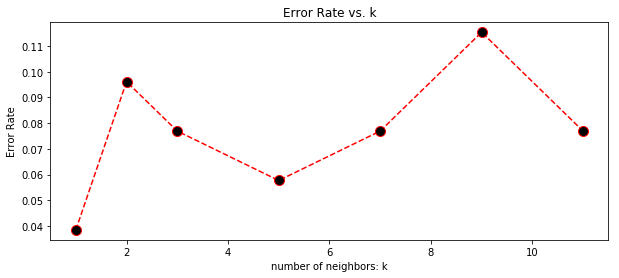

In [135]:
plt.figure(figsize = (10, 4))
#ax = plt.gca()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.plot([1,2,3,5,7,9,11], error_rate , color='red', linestyle='dashed',
            marker='o', markerfacecolor='black', markersize=10) 
plt.title('Error Rate vs. k')
plt.xlabel('number of neighbors: k')
plt.ylabel('Error Rate')